In [77]:
import numpy as np 
import scipy.stats as ss 
import matplotlib.pylab as plt 

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

### Assumptions

- Model 2 is always the extended model.

In [348]:
param1 = [-1.0, 4.0]
param2 = [4.0, 0.75] # [-1.0, 4.0, 0.1] # [-1.0, 4.0] # 
nparam1 = len(param1)
nparam2 = len(param2)
priorwidth = 10.0
priorcov1 = np.eye(nparam1) * priorwidth
priorcov2 = np.eye(nparam2) * priorwidth

minx = 0.0 
maxx = np.pi 
ndata = 100
domain = np.linspace(minx, maxx, ndata)
grad1 =  np.vstack([domain**2, domain]).T
# grad2 = np.vstack([domain**3, domain, np.ones(ndata)]).T # 

gradient_param_0 = np.sin(param2[1] * domain)
gradient_param_1 = param2[0] * domain * np.cos(param2[1] * domain)
grad2 = np.vstack([gradient_param_0, gradient_param_1]).T
        
sigma = 1.0
noise_cov = np.diag(np.ones(ndata)*sigma**2)

In [349]:
def model_1(param, domain):
    return param[0]*domain**2 + param[1]*domain

def model_2(param, domain):
    return param[0] * np.sin(param[1]*domain) # param[0]*domain**3 + param[1]*domain #    + param[2]

In [350]:
mu_fid_1 = model_1(param1, domain)
data = mu_fid_1 + sigma*np.random.randn(ndata)
X1 = data - mu_fid_1

### Full Data

In [351]:
covdata1 = noise_cov + grad1 @ priorcov1 @ grad1.T
covdata2 = noise_cov + grad2 @ priorcov2 @ grad2.T

In [352]:
evi1 = ss.multivariate_normal(np.zeros(ndata), covdata1)
evi2 = ss.multivariate_normal(np.zeros(ndata), covdata2)

In [353]:
evi1.logpdf(X1)

-146.61368794483406

In [354]:
evi2.logpdf(X1)

-146.90587433331396

In [355]:
evi1.logpdf(X1) - evi2.logpdf(X1)

0.2921863884799052

### Compression

In [356]:
b1_mat = np.linalg.inv(noise_cov) @ grad1
b2_mat = np.linalg.inv(noise_cov) @ grad2

In [357]:
lambda_1 = b1_mat.T @ noise_cov @ b1_mat
lambda_2 = b2_mat.T @ noise_cov @ b2_mat

In [358]:
# cov_comp_1 = lambda_1 + lambda_1 @ priorcov1 @ lambda_1
cov_comp_2 = lambda_2 + lambda_2 @ priorcov2 @ lambda_2

# modified covariance for first model 
wmat = grad2.T @ np.linalg.inv(noise_cov) @ grad1
cov_comp_1 = lambda_2 + wmat @ priorcov1 @ wmat.T

In [359]:
ycomp = b2_mat.T @ X1

In [360]:
comp_evi1 = ss.multivariate_normal(np.zeros(nparam2), cov_comp_1)
comp_evi2 = ss.multivariate_normal(np.zeros(nparam2), cov_comp_2)

In [361]:
comp_evi1.logpdf(ycomp)

-15.010429653302932

In [362]:
comp_evi2.logpdf(ycomp)

-15.263488261135727

In [363]:
comp_evi1.logpdf(ycomp) - comp_evi2.logpdf(ycomp)

0.253058607832795

### Extended Matrices

In [364]:
from scipy.linalg import block_diag

In [365]:
nparam_tot = nparam1 + nparam2

In [366]:
b_mat_ex = np.concatenate([b1_mat, b2_mat], axis = 1)
grad_ex = np.concatenate([grad1, grad2], axis = 1)
lam_ex = grad_ex.T @ np.linalg.inv(noise_cov) @ grad_ex

In [367]:
lam_1_ex = lam_ex + b_mat_ex.T @ grad1 @ priorcov1 @ grad1.T @ b_mat_ex
lam_2_ex = lam_ex + b_mat_ex.T @ grad2 @ priorcov2 @ grad2.T @ b_mat_ex

In [368]:
ex_comp_evi1 = ss.multivariate_normal(np.zeros(nparam_tot), lam_1_ex, allow_singular=True)
ex_comp_evi2 = ss.multivariate_normal(np.zeros(nparam_tot), lam_2_ex, allow_singular=True)

In [369]:
ex_ycomp = b_mat_ex.T @ X1

In [370]:
ex_comp_evi1.logpdf(ex_ycomp)

-16.024593658125532

In [371]:
ex_comp_evi2.logpdf(ex_ycomp)

-16.31678004242146

In [372]:
ex_comp_evi1.logpdf(ex_ycomp) - ex_comp_evi2.logpdf(ex_ycomp)

0.2921863842959276

# Repetitions

In [379]:
record_full = list()
record_comp = list()
record_comp_alan = list()
evi_1_full = list()
evi_2_full = list()
evi_1_comp = list()
evi_2_comp = list()
evi_1_comp_alan = list()
evi_2_comp_alan = list()
ntrials = 5000

for i in range(ntrials):
    data = mu_fid_1 + sigma*np.random.randn(ndata)
    X1 = data - mu_fid_1
    ycomp = b2_mat.T @ X1
    ex_ycomp = b_mat_ex.T @ X1
    
    evi_1 = evi1.logpdf(X1)
    evi_2 = evi2.logpdf(X1)
    evi_c_1 = comp_evi1.logpdf(ycomp)
    evi_c_2 = comp_evi2.logpdf(ycomp)
    
    evi_c_a_1 = ex_comp_evi1.logpdf(ex_ycomp)
    evi_c_a_2 = ex_comp_evi2.logpdf(ex_ycomp)

    evi_1_full.append(evi_1)
    evi_2_full.append(evi_2)
    evi_1_comp.append(evi_c_1)
    evi_2_comp.append(evi_c_2)
    evi_1_comp_alan.append(evi_c_a_1)
    evi_2_comp_alan.append(evi_c_a_2)
    
    record_full.append(evi_1 - evi_2)
    record_comp.append(evi_c_1 - evi_c_2)
    record_comp_alan.append(evi_c_a_1 - evi_c_a_2)

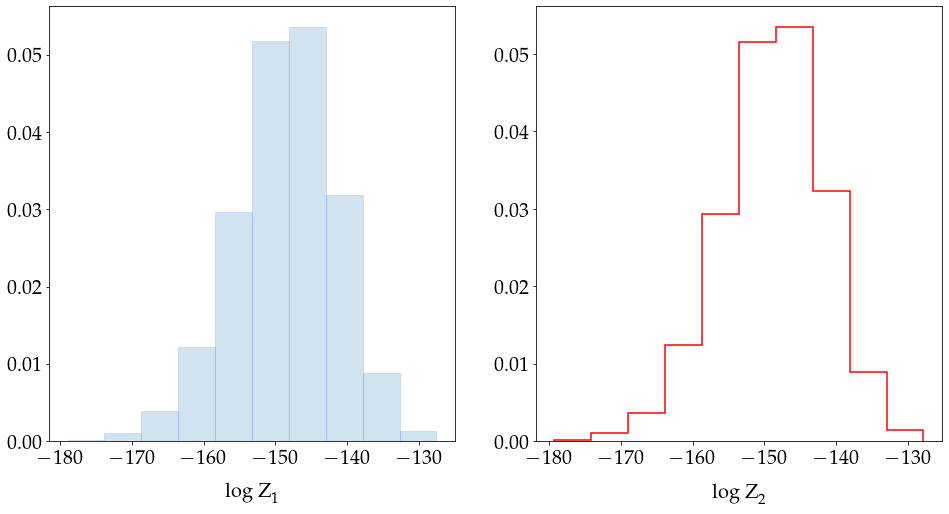

In [374]:
plt.figure(figsize = (16,8))
plt.subplot(121)
plt.hist(evi_1_full, density = True, edgecolor='b', linewidth=0.5, label = 'Full Data', alpha = 0.2)
plt.xlabel(r'$\textrm{log Z}_{1}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplot(122)
plt.hist(evi_2_full, density = True, edgecolor='r', linewidth=1.5, label = 'Compressed Data', histtype='step')
plt.xlabel(r'$\textrm{log Z}_{2}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

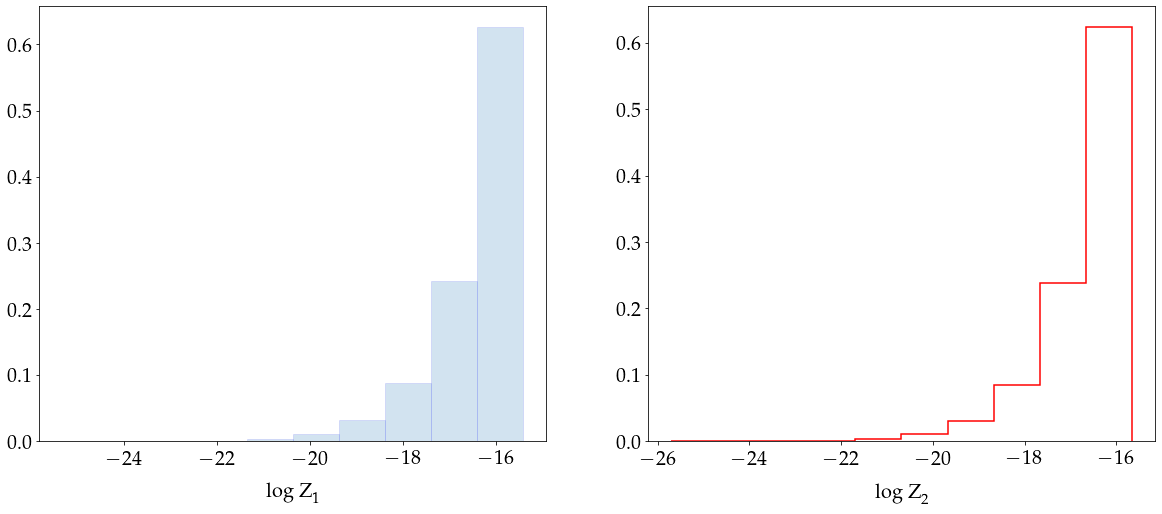

In [380]:
plt.figure(figsize = (20,8))
plt.subplot(121)
# plt.hist(evi_1_comp, density = True, edgecolor='b', linewidth=0.5, label = 'Full Data', alpha = 0.2)
plt.hist(evi_1_comp_alan, density = True, edgecolor='b', linewidth=0.5, label = 'Full Data', alpha = 0.2)
plt.xlabel(r'$\textrm{log Z}_{1}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplot(122)
# plt.hist(evi_2_comp, density = True, edgecolor='r', linewidth=1.5, label = 'Compressed Data', histtype='step')
plt.hist(evi_2_comp_alan, density = True, edgecolor='r', linewidth=1.5, label = 'Compressed Data', histtype='step')
plt.xlabel(r'$\textrm{log Z}_{2}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

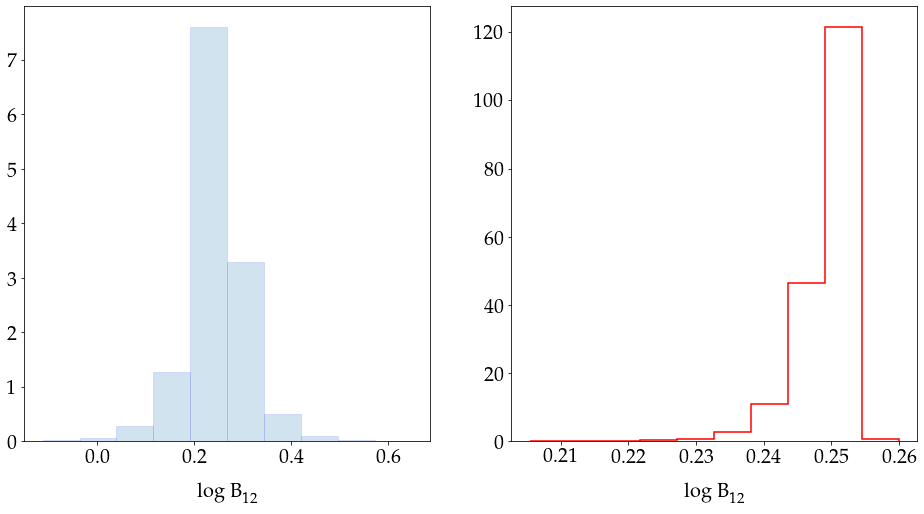

In [376]:
plt.figure(figsize = (16,8))
plt.subplot(121)
plt.hist(record_full, density = True, edgecolor='b', linewidth=0.5, label = 'Full Data', alpha = 0.2)
plt.xlabel(r'$\textrm{log B}_{12}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplot(122)
plt.hist(record_comp, density = True, edgecolor='r', linewidth=1.5, label = 'Compressed Data', histtype='step')
plt.xlabel(r'$\textrm{log B}_{12}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

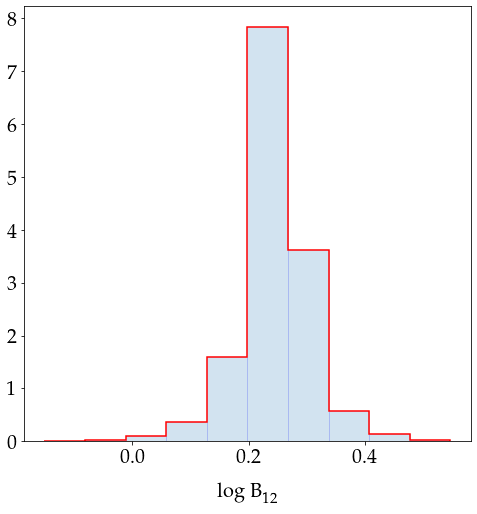

In [381]:
plt.figure(figsize = (8,8))
plt.hist(record_full, density = True, edgecolor='b', linewidth=0.5, label = 'Full Data', alpha = 0.2)
plt.hist(record_comp_alan, density = True, edgecolor='r', linewidth=1.5, label = 'Compressed Data', histtype='step')
plt.xlabel(r'$\textrm{log B}_{12}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

### Full data

In [382]:
np.mean(record_full), np.std(record_full)

(0.24669383588144733, 0.061171326678351595)

### Using one of the models (extended)

In [383]:
np.mean(record_comp), np.std(record_comp)

(0.2488523875857691, 0.0037004184188151245)

### Alan

In [384]:
np.mean(record_comp_alan), np.std(record_comp_alan)

(0.24669383432604408, 0.06117132595591677)